# Workgroup 2 - Group 7

## Sample Splitting

Sample Splitting consists in randomly splitting the data we have into two groups: one training sample and one testing sample. We use the training sample to estimate the coefficients of our regression (1). Then we use said coefficients to predict the testing sample (2) and we contrast the fitted values to the sample dependent variables. This process helps us test how the coefficients perform outside their regression and see whether or not they keep their predictive value.

\begin{equation}\label{training}
Y_{tr}= X_{tr}\beta_{tr}+ \epsilon_{tr}\tag{1}.
\end{equation}

\begin{equation}\label{testing}
Y_{ts}= X_{ts}\beta_{tr}+ \epsilon_{ts}\tag{2}.
\end{equation}

## Data Analysis

In [2]:
import pandas as pd
import numpy as np
import pyreadr
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LassoCV
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

rdata_read = pyreadr.read_r("data/wage2015_subsample_inference.Rdata")
data = rdata_read[ 'data' ]
data = data[(data['hsg'] == 1) | (data['shs'] == 1)] 

type(data)
data.shape

(1376, 20)

In [3]:
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 1376 entries, 15 to 32631
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   wage    1376 non-null   float64 
 1   lwage   1376 non-null   float64 
 2   sex     1376 non-null   float64 
 3   shs     1376 non-null   float64 
 4   hsg     1376 non-null   float64 
 5   scl     1376 non-null   float64 
 6   clg     1376 non-null   float64 
 7   ad      1376 non-null   float64 
 8   mw      1376 non-null   float64 
 9   so      1376 non-null   float64 
 10  we      1376 non-null   float64 
 11  ne      1376 non-null   float64 
 12  exp1    1376 non-null   float64 
 13  exp2    1376 non-null   float64 
 14  exp3    1376 non-null   float64 
 15  exp4    1376 non-null   float64 
 16  occ     1376 non-null   category
 17  occ2    1376 non-null   category
 18  ind     1376 non-null   category
 19  ind2    1376 non-null   category
dtypes: category(4), float64(16)
memory usage: 213.0+ KB


,wage,lwage,sex,shs,hsg,scl,clg,ad,mw,so,we,ne,exp1,exp2,exp3,exp4
count,1376.000000,1376.000000,1376.000000,1376.000000,1376.000000,1376.0,1376.0,1376.0,1376.000000,1376.000000,1376.000000,1376.000000,1376.000000,1376.000000,1376.000000,1376.000000
mean,17.854354,2.718562,0.321948,0.087209,0.912791,0.0,0.0,0.0,0.286337,0.291424,0.198401,0.223837,17.190044,4.029529,11.434386,36.158301
std,22.153617,0.504167,0.467393,0.282244,0.282244,0.0,0.0,0.0,0.452213,0.454584,0.398941,0.416966,10.369836,4.464939,17.304596,67.243707
min,3.365385,1.213542,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,5.000000,0.250000,0.125000,0.062500
25%,10.989011,2.396896,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,9.000000,0.810000,0.729000,0.656100
50%,14.615385,2.682075,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,14.000000,1.960000,2.744000,3.841600
75%,20.097115,3.000573,1.000000,0.000000,1.000000,0.0,0.0,0.0,1.000000,1.000000,0.000000,0.000000,25.000000,6.250000,15.625000,39.062500
max,528.845673,6.270697,1.000000,1.000000,1.000000,0.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000,47.000000,22.090000,103.823000,487.968100


In [4]:
Y = np.log2(data['wage']) 
n = len(Y)
z = data.loc[:, ~data.columns.isin(['wage', 'lwage','Unnamed: 0'])]
p = z.shape[1]

print("Number of observation:", n, '\n')
print( "Number of raw regressors:", p)

Number of observation: 1376 

Number of raw regressors: 18


In [5]:
Z_subset = data.loc[:, data.columns.isin(["lwage","sex","shs","hsg","mw","so","we","ne","exp1"])]
table = Z_subset.mean(axis=0)
table

lwage     2.718562
sex       0.321948
shs       0.087209
hsg       0.912791
mw        0.286337
so        0.291424
we        0.198401
ne        0.223837
exp1     17.190044
dtype: float64

In [6]:
table = pd.DataFrame(data=table, columns={"Sample mean":"0"} )
table.index
index1 = list(table.index)
index2 = ["Log Wage","Sex","Some High School","High School Graduate",\
          "Midwest",\
          "South","West","Northeast","Experience"]
table = table.rename(index=dict(zip(index1,index2)))
table

,Sample mean
Log Wage,2.718562
Sex,0.321948
Some High School,0.087209
High School Graduate,0.912791
Midwest,0.286337
South,0.291424
West,0.198401
Northeast,0.223837
Experience,17.190044


## Prediction Question

We construct a prediction rule for hourly wage $Y$ for the people who did not go to college (high school graduates or with some high school education), which depends on job-relevant characteristics $X$:

\begin{equation}\label{decompose}
Y = \beta'X+ \epsilon.
\end{equation}

We aim to predict wages using the exogenous characteristics of workers. For this purpose, we use two different specifications for prediction:

1. Basic Model: $X$ consists of a set of raw regressors: Sex, Experience, Education, Occupation, Region, etc.

2. Flexible Model: $X$ consists of all raw regressors from the basic model plus their transformations and two-way interactions. We define these by expressing our set of regressors as:
\begin{equation}\label{regressor}
X=(X_1 + X_2 + X_3+...)^2
\end{equation}

In the following sections, we will estimate both models using the OLS method and the Lasso method.

### _OLS - Basic Model_


In [7]:
basic = 'lwage ~ sex + exp1 + shs + hsg + mw + so + we + occ2+ ind2'
basic_results = smf.ols(basic , data=data).fit()
print(basic_results.summary()) # estimated coefficients

                            OLS Regression Results                            
Dep. Variable:                  lwage   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     6.212
Date:                Fri, 17 Sep 2021   Prob (F-statistic):           9.07e-33
Time:                        11:52:17   Log-Likelihood:                -872.87
No. Observations:                1376   AIC:                             1842.
Df Residuals:                    1328   BIC:                             2093.
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0216      0.062     32.368      0.0

In [8]:
print( "Number of regressors in the basic model:",len(basic_results.params), '\n') 

Number of regressors in the basic model: 49 



### _OLS - Flexible Model_

In [9]:

flex = 'lwage ~ (exp1+exp2+exp3+exp4+shs+hsg+scl+clg+occ2+ind2+mw+so+we)**2'
flex_results_0 = smf.ols(flex , data=data)
flex_results = smf.ols(flex , data=data).fit()
print(flex_results.summary()) # estimated coefficients


                            OLS Regression Results                            
Dep. Variable:                  lwage   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     1.840
Date:                Fri, 17 Sep 2021   Prob (F-statistic):           2.24e-15
Time:                        11:52:19   Log-Likelihood:                -522.96
No. Observations:                1376   AIC:                             2034.
Df Residuals:                     882   BIC:                             4616.
Df Model:                         493                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 3.63

In [10]:
print( "Number of regressors in the basic model:",len(flex_results.params), '\n')

Number of regressors in the basic model: 979 



Note that the basic model only includes $49$ regressors, while the flexible model includes $979$ regressors.

###  _Lasso - Basic Model_

In [11]:
# Get exogenous variables from basic and flexible model
X_basic=smf.ols(basic , data=data).exog
X_flex = flex_results_0.exog

# Set endogenous variable
lwage = data["lwage"]
lwage.shape

(1376,)

In the case of the flexible model, we noticed that sometiomes the model does not converege due to the large number of regressors (especifically, in the case of the Flexible Model). To solve this problem, we adjust the restriction $\alpha$. Here we compare the $R^2$ of the same basic model, but with different $\alpha$ in order to see which one is better.

In [12]:
# We try with multiple alpha values to see how the model adjusts depending on alpha value
alphavec = np.arange(start = 0.05,stop = 1,step = 0.05)
alphavec = np.array([alphavec])
print(alphavec)

table_basic_model = np.zeros((alphavec.size, 2))
table_basic_model

[[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
  0.75 0.8  0.85 0.9  0.95]]


array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [13]:


for element in range(0,alphavec.size):
    al = alphavec[0, element] 
    reg = linear_model.Lasso(alpha = al)
    reg.fit(X_basic, lwage)
    lwage1_lasso_fitted = reg.fit(X_basic, lwage).predict( X_basic)
    reg.coef_
    table_basic_model[element, 0] = al
    table_basic_model[element, 1] = reg.score(X_basic, lwage)
    print(f'Lasso Regression - Basic Model: R^2 score  {reg.score(X_basic, lwage)} when alpha = {al} ')

Lasso Regression - Basic Model: R^2 score  0.028880138580785975 when alpha = 0.05 
Lasso Regression - Basic Model: R^2 score  0.028605348901849403 when alpha = 0.1 
Lasso Regression - Basic Model: R^2 score  0.028147366103621674 when alpha = 0.15000000000000002 
Lasso Regression - Basic Model: R^2 score  0.027506190186102786 when alpha = 0.2 
Lasso Regression - Basic Model: R^2 score  0.026681821149293072 when alpha = 0.25 
Lasso Regression - Basic Model: R^2 score  0.025674258993191867 when alpha = 0.3 
Lasso Regression - Basic Model: R^2 score  0.024483503717799837 when alpha = 0.35000000000000003 
Lasso Regression - Basic Model: R^2 score  0.02310955532311676 when alpha = 0.4 
Lasso Regression - Basic Model: R^2 score  0.021552413809142412 when alpha = 0.45 
Lasso Regression - Basic Model: R^2 score  0.019812079175876907 when alpha = 0.5 
Lasso Regression - Basic Model: R^2 score  0.017888551423320687 when alpha = 0.55 
Lasso Regression - Basic Model: R^2 score  0.015781830551473197

In [14]:
table_basic_model = pd.DataFrame(data = table_basic_model, columns={"Alpha":"0", "R^2" : "1"})
table_basic_model

,Alpha,R^2
0,0.05,0.028880
1,0.10,0.028605
2,0.15,0.028147
3,0.20,0.027506
4,0.25,0.026682
5,0.30,0.025674
6,0.35,0.024484
7,0.40,0.023110
8,0.45,0.021552
9,0.50,0.019812


We can appreciate how the $R^2$ decresaes when the penalization parameter increases.

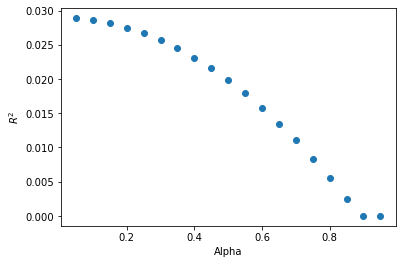

In [15]:
import matplotlib.pyplot as plt
plt.scatter('Alpha', 'R^2', data = table_basic_model)
plt.xlabel('Alpha')
plt.ylabel('$R^2$')
plt.show()

As we can see, the $R^2$ decreases when alpha takes higher values, and there was no convergece problem.

###  _Lasso - Flexible Model_

In [16]:
# We try with multiple alpha values to see how the model adjusts depending on alpha value such as the previous section.
alphavec = np.arange(start = 0.05,stop = 1,step = 0.05)
alphavec = np.array([alphavec])
print(alphavec)

table_flex_model = np.zeros((alphavec.size, 2))
table_flex_model 

[[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
  0.75 0.8  0.85 0.9  0.95]]


array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [17]:

for element in range(0,alphavec.size):
    al = alphavec[0, element] 
    reg = linear_model.Lasso(alpha = al)
    reg.fit(X_flex, lwage)
    lwage1_lasso_fitted = reg.fit(X_flex, lwage).predict( X_flex)
    reg.coef_
    table_flex_model[element, 0] = al
    table_flex_model[element, 1] = reg.score(X_flex, lwage)
    print(f'Lasso Regression - Basic Model: R^2 score  {reg.score(X_flex, lwage)} when alpha = {al} ')

/Applications/Anaconda/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90.76176097554642, tolerance: 0.0349503284207476
  model = cd_fast.enet_coordinate_descent(
/Applications/Anaconda/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90.76176097554642, tolerance: 0.0349503284207476
  model = cd_fast.enet_coordinate_descent(


Lasso Regression - Basic Model: R^2 score  0.1724485594774805 when alpha = 0.05 


/Applications/Anaconda/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66.32572320318863, tolerance: 0.0349503284207476
  model = cd_fast.enet_coordinate_descent(
/Applications/Anaconda/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66.32572320318863, tolerance: 0.0349503284207476
  model = cd_fast.enet_coordinate_descent(


Lasso Regression - Basic Model: R^2 score  0.13504437453298423 when alpha = 0.1 


/Applications/Anaconda/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45.867877820044384, tolerance: 0.0349503284207476
  model = cd_fast.enet_coordinate_descent(
/Applications/Anaconda/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45.867877820044384, tolerance: 0.0349503284207476
  model = cd_fast.enet_coordinate_descent(


Lasso Regression - Basic Model: R^2 score  0.10691827531230746 when alpha = 0.15000000000000002 


/Applications/Anaconda/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.622239597446168, tolerance: 0.0349503284207476
  model = cd_fast.enet_coordinate_descent(
/Applications/Anaconda/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.622239597446168, tolerance: 0.0349503284207476
  model = cd_fast.enet_coordinate_descent(


Lasso Regression - Basic Model: R^2 score  0.08983057313693599 when alpha = 0.2 


/Applications/Anaconda/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.393606751947175, tolerance: 0.0349503284207476
  model = cd_fast.enet_coordinate_descent(
/Applications/Anaconda/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.393606751947175, tolerance: 0.0349503284207476
  model = cd_fast.enet_coordinate_descent(


Lasso Regression - Basic Model: R^2 score  0.07502250972306301 when alpha = 0.25 


/Applications/Anaconda/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.45881104444043785, tolerance: 0.0349503284207476
  model = cd_fast.enet_coordinate_descent(
/Applications/Anaconda/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.45881104444043785, tolerance: 0.0349503284207476
  model = cd_fast.enet_coordinate_descent(


Lasso Regression - Basic Model: R^2 score  0.06460044615053617 when alpha = 0.3 


/Applications/Anaconda/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7616387976610781, tolerance: 0.0349503284207476
  model = cd_fast.enet_coordinate_descent(
/Applications/Anaconda/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7616387976610781, tolerance: 0.0349503284207476
  model = cd_fast.enet_coordinate_descent(


Lasso Regression - Basic Model: R^2 score  0.059358850434744426 when alpha = 0.35000000000000003 
Lasso Regression - Basic Model: R^2 score  0.054428042189907044 when alpha = 0.4 
Lasso Regression - Basic Model: R^2 score  0.05044156892056162 when alpha = 0.45 
Lasso Regression - Basic Model: R^2 score  0.04822036735322577 when alpha = 0.5 
Lasso Regression - Basic Model: R^2 score  0.04607529178058578 when alpha = 0.55 
Lasso Regression - Basic Model: R^2 score  0.04392910396703886 when alpha = 0.6000000000000001 


/Applications/Anaconda/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03609545660509639, tolerance: 0.0349503284207476
  model = cd_fast.enet_coordinate_descent(
/Applications/Anaconda/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03609545660509639, tolerance: 0.0349503284207476
  model = cd_fast.enet_coordinate_descent(


Lasso Regression - Basic Model: R^2 score  0.04138038917122844 when alpha = 0.6500000000000001 
Lasso Regression - Basic Model: R^2 score  0.03874463654542415 when alpha = 0.7000000000000001 
Lasso Regression - Basic Model: R^2 score  0.03664086923774201 when alpha = 0.7500000000000001 
Lasso Regression - Basic Model: R^2 score  0.03521262106138923 when alpha = 0.8 
Lasso Regression - Basic Model: R^2 score  0.033798199634407666 when alpha = 0.8500000000000001 
Lasso Regression - Basic Model: R^2 score  0.03258460874742619 when alpha = 0.9000000000000001 
Lasso Regression - Basic Model: R^2 score  0.031538026414294484 when alpha = 0.9500000000000001 


In [18]:
table_flex_model = pd.DataFrame(data = table_flex_model, columns={"Alpha":"0", "R^2" : "1"})
table_flex_model

,Alpha,R^2
0,0.05,0.172449
1,0.10,0.135044
2,0.15,0.106918
3,0.20,0.089831
4,0.25,0.075023
5,0.30,0.064600
6,0.35,0.059359
7,0.40,0.054428
8,0.45,0.050442
9,0.50,0.048220


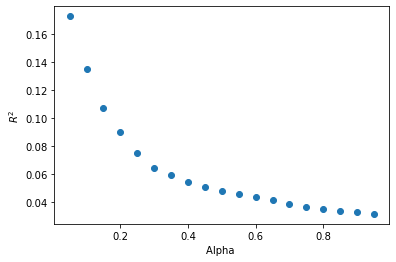

In [19]:
plt.scatter('Alpha', 'R^2', data = table_flex_model)
plt.xlabel('Alpha ')
plt.ylabel('$R^2$')
plt.show()

As we can see, the Lasso regression usually does not converge with lower $\alpha$ values. This is because a higher alpha is more restrictive, and therefore more varibles with less predictive value are discarded.

### _Performance Evaluation_
Now, we can evaluate the performance of both models based on the (adjusted) $R^2_{sample}$ and the (adjusted) $MSE_{sample}$:

In [20]:
lwage = data["lwage"]
lwage.shape

# Basic Model
basic = 'lwage ~ sex + exp1 + shs + hsg + mw + so + we + occ2+ ind2'
basic_results_0 =smf.ols(basic , data=data)
basic_results = smf.ols(basic , data=data).fit()
xb = basic_results_0.exog

# Flexible model 
flex = 'lwage ~ (exp1+exp2+exp3+exp4+shs+hsg+scl+clg+occ2+ind2+mw+so+we)**2'
flex_results_0 = smf.ols(flex , data=data)
flex_results = smf.ols(flex , data=data).fit()
xf = flex_results_0.exog

#Lasso Basic
lasso_basic = linear_model.Lasso(alpha = 0.1)
lasso_basic.fit(xb, lwage)
lwage_lasso_b_fitted = lasso_basic.fit(xb, lwage).predict( xb )

#Lasso Flex
lasso_flex = linear_model.Lasso(alpha = 0.40)
lasso_flex.fit(xf, lwage)
lwage_lasso_f_fitted = lasso_flex.fit(xf, lwage).predict( xf )


In [21]:
# Assess the predictive performance of each model
R2_1 = basic_results.rsquared
print("R-squared for the basic model: ", R2_1, "\n")
R2_adj1 = basic_results.rsquared_adj
print("adjusted R-squared for the basic model: ", R2_adj1, "\n")


R2_2 = flex_results.rsquared
print("R-squared for the basic model: ", R2_2, "\n")
R2_adj2 = flex_results.rsquared_adj
print("adjusted R-squared for the basic model: ", R2_adj2, "\n")

R2_L_b = lasso_basic.score(xb, lwage)
print("R-squared for Basic LASSO: ", R2_L_b, "\n")
R2_adjL_b = 1 - (1-R2_L_b)*(len(lwage)-1)/(len(lwage)-xb.shape[1]-1)
print("adjusted R-squared for Basic LASSO: ", R2_adjL_b, "\n")

R2_L_f = lasso_flex.score(xf, lwage)
print("R-squared for Flex LASSO: ", R2_L_f, "\n")
R2_adjL_f = 1 - (1-R2_L_f)*(len(lwage)-1)/(len(lwage)-xf.shape[1]-1)
print("adjusted R-squared for Flex LASSO: ", R2_adjL_f, "\n")

R-squared for the basic model:  0.18023814876721023 

adjusted R-squared for the basic model:  0.15122549288773646 

R-squared for the basic model:  0.507044001363497 

adjusted R-squared for the basic model:  0.2315028365927534 

R-squared for Basic LASSO:  0.028605348901849403 

adjusted R-squared for Basic LASSO:  -0.007290833529379315 

R-squared for Flex LASSO:  0.054428042189907044 

adjusted R-squared for Flex LASSO:  -2.2832359646183784 



$R^2$ values for Lasso regressions are too small, this makes the $AdjR^2$ a negative number!

In [22]:
# calculating the MSE
MSE1 =  np.mean(basic_results.resid**2)
print("MSE for the basic model: ", MSE1, "\n")
p1 = len(basic_results.params) # number of regressors
n = len(lwage)
MSE_adj1  = (n/(n-p1))*MSE1
print("adjusted MSE for the basic model: ", MSE_adj1, "\n")

MSE2 =  np.mean(flex_results.resid**2)
print("MSE for the flexible model: ", MSE2, "\n")
p2 = len(flex_results.params) # number of regressors
n = len(lwage)
MSE_adj2  = (n/(n-p2))*MSE2
print("adjusted MSE for the flexible model: ", MSE_adj2, "\n")


MSELB = mean_squared_error(lwage, lwage_lasso_b_fitted)
print("MSE for the Basic LASSO model: ", MSELB, "\n")
pLb = lasso_basic.coef_.shape[0] # number of regressors
n = len(lwage)
MSE_adjL_B  = (n/(n-pLb))*MSELB
print("adjusted MSE for Basic LASSO model: ", MSE_adjL_B, "\n")


MSELF = mean_squared_error(lwage, lwage_lasso_f_fitted)
print("MSE for the Flex LASSO model: ", MSELF, "\n")
pLf = lasso_flex.coef_.shape[0] # number of regressors
n = len(lwage)
MSE_adjL_F  = (n/(n-pLf))*MSELF
print("adjusted MSE for Basic LASSO model: ", MSE_adjL_F, "\n")

MSE for the basic model:  0.20821908377460763 

adjusted MSE for the basic model:  0.21590765582054264 

MSE for the flexible model:  0.12521056721891985 

adjusted MSE for the flexible model:  0.4339791951970623 

MSE for the Basic LASSO model:  0.24673373606132187 

adjusted MSE for Basic LASSO model:  0.25584447688046635 

MSE for the Flex LASSO model:  0.24017478539907006 

adjusted MSE for Basic LASSO model:  0.8324445962446358 



The Basic Lasso Model has the lowest $AsjMSE$. 

In [23]:
table = np.zeros((4, 5))
table[0,0:5] = [p1, R2_1, MSE1, R2_adj1, MSE_adj1]
table[1,0:5] = [p2, R2_2, MSE2, R2_adj2, MSE_adj2]
table[2,0:5] = [pLb, R2_L_b, MSELB, R2_adjL_b, MSE_adjL_B]
table[3,0:5] = [pLf, R2_L_f, MSELF, R2_adjL_f, MSE_adjL_F]
table

array([[ 4.90000000e+01,  1.80238149e-01,  2.08219084e-01,
         1.51225493e-01,  2.15907656e-01],
       [ 9.79000000e+02,  5.07044001e-01,  1.25210567e-01,
         2.31502837e-01,  4.33979195e-01],
       [ 4.90000000e+01,  2.86053489e-02,  2.46733736e-01,
        -7.29083353e-03,  2.55844477e-01],
       [ 9.79000000e+02,  5.44280422e-02,  2.40174785e-01,
        -2.28323596e+00,  8.32444596e-01]])

In [24]:
table = pd.DataFrame(table, columns = ["p","$R^2_{sample}$","$MSE_{sample}$","$R^2_{adjusted}$", "$MSE_{adjusted}$"], \
                      index = ["basic reg","flexible reg", "lasso basic", "lasso flex"])
table

,p,$R^2_{sample}$,$MSE_{sample}$,$R^2_{adjusted}$,$MSE_{adjusted}$
basic reg,49.0,0.180238,0.208219,0.151225,0.215908
flexible reg,979.0,0.507044,0.125211,0.231503,0.433979
lasso basic,49.0,0.028605,0.246734,-0.007291,0.255844
lasso flex,979.0,0.054428,0.240175,-2.283236,0.832445


We see that the Flexible model has a higher $R^2_{adjusted}$ and a lower $MSE$, although not the lowest $MSE_{adjusted}$; the model with the lowest $MSE_{adjusted}$ is the basic regression. To see which model performs better, we analize the estimators using Data Splitting.

## Data Splitting

As explained in the first section, here we split our data into training sample and testing sample in order to asses the predictive power of the different models. We do so for each model, basic and flexible, and using two different methods, OLS and Lasso.


In [25]:
import random
import math

np.random.seed(0)
random = np.random.randint(0,n, size=math.floor(n))
data['random'] = random
random 

<ipython-input-25-4ade4604cf3e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['random'] = random


array([ 684,  559, 1216, ..., 1294,  573, 1367])

In [26]:
data_2 = data.sort_values(by=['random'])
data_2.head()

,wage,lwage,sex,shs,hsg,scl,clg,ad,mw,so,...,ne,exp1,exp2,exp3,exp4,occ,occ2,ind,ind2,random
rownames,,,,,,,,,,,,,,,,,,,,,
9262,9.134615,2.212071,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,5.0,0.25,0.125,0.0625,9360,22,5090,9,0
14134,24.038462,3.179655,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,11.0,1.21,1.331,1.4641,4250,14,7770,16,0
8689,12.980769,2.563469,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,17.0,2.89,4.913,8.3521,5620,17,5380,9,3
11486,12.980769,2.563469,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,7.0,0.49,0.343,0.2401,4760,16,5790,9,3
20866,34.615385,3.544298,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,5.0,0.25,0.125,0.0625,220,1,770,4,3


In [27]:
# Create training and testing sample 
train = data_2[ : math.floor(n*4/5)]    # training sample
test =  data_2[ math.floor(n*4/5) : ]   # testing sample
print(train.shape)
print(test.shape)

(1100, 21)
(276, 21)


In [28]:
# Basic Model
basic = 'lwage ~ sex + exp1 + shs + hsg + mw + so + we + occ2+ ind2'
basic_results = smf.ols(basic , data=data).fit()

# Flexible model 
flex = 'lwage ~ (exp1+exp2+exp3+exp4+shs+hsg+scl+clg+occ2+ind2+mw+so+we)**2'
flex_results = smf.ols(flex , data=data).fit()

### _Basic Regression_

In [29]:
# estimating the parameters in the training sample
basic_results = smf.ols(basic , data=train).fit()
print(basic_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  lwage   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     5.265
Date:                Fri, 17 Sep 2021   Prob (F-statistic):           2.13e-25
Time:                        11:52:35   Log-Likelihood:                -711.67
No. Observations:                1100   AIC:                             1519.
Df Residuals:                    1052   BIC:                             1759.
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0547      0.071     28.859      0.0

In [30]:
lwage_test = test["lwage"].values
test


,wage,lwage,sex,shs,hsg,scl,clg,ad,mw,so,...,ne,exp1,exp2,exp3,exp4,occ,occ2,ind,ind2,random
rownames,,,,,,,,,,,,,,,,,,,,,
30171,14.423077,2.668829,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.2500,0.125000,0.062500,6230,19,770,4,1120
20062,11.692308,2.458931,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,15.0,2.2500,3.375000,5.062500,4760,16,4680,9,1121
26099,5.770192,1.752705,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,10.5,1.1025,1.157625,1.215506,5240,17,7590,16,1123
29638,12.000000,2.484907,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.2500,0.125000,0.062500,6520,19,770,4,1123
24679,14.423077,2.668829,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,43.0,18.4900,79.507000,341.880100,8965,21,1990,5,1124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5201,10.096154,2.312155,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,9.0,0.8100,0.729000,0.656100,4620,15,8290,18,1371
9639,19.230769,2.956512,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,9.0,0.8100,0.729000,0.656100,7810,21,5380,9,1371
15695,8.173077,2.100845,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,5.0,0.2500,0.125000,0.062500,4430,15,8590,19,1372


In [31]:
# calculating the out-of-sample MSE
test = sm.add_constant(test)   #add constant 
lwage_pred =  basic_results.predict(test) # predict out of sample
print(lwage_pred)

rownames
30171    2.849302
20062    2.635376
26099    2.518647
29638    2.849302
24679    2.917170
           ...   
5201     2.528900
9639     2.805803
15695    2.242189
3853     2.914903
20067    2.408205
Length: 276, dtype: float64


In [32]:
MSE_test1 = np.sum((lwage_test-lwage_pred)**2)/len(lwage_test)
R2_test1  = 1 - MSE_test1/np.var(lwage_test)

print("Test MSE for the basic model: ", MSE_test1, " ")
print("Test R2 for the basic model: ", R2_test1)

Test MSE for the basic model:  0.19987102511489924  
Test R2 for the basic model:  0.04156410192333715


In the basic model, the $MSE_{test}$ is quite close to the $MSE_{sample}$.

### _Flexible Regression_

In [33]:
# estimating the parameters in the training sample
flex_results = smf.ols(flex , data=train).fit()

# calculating the out-of-sample MSE
lwage_flex_pred =  flex_results.predict(test) # predict out of sample
lwage_test = test["lwage"].values

MSE_test2 = np.sum((lwage_test-lwage_flex_pred)**2)/len(lwage_test)
R2_test2  = 1 - MSE_test2/np.var(lwage_test)

print("Test MSE for the flexible model: ", MSE_test2, " ")
print("Test R2 for the flexible model: ", R2_test2)

Test MSE for the flexible model:  21.548829406733578  
Test R2 for the flexible model:  -102.33249480794264


### _Lasso - Basic Regression_

In [34]:
# get exogenous variables from training data used in flex model
flex_results_b = smf.ols(basic , data=train)
Xb_train = flex_results_b.exog
print(Xb_train.shape)

# Get endogenous variable 
lwage_train = train["lwage"]
print(lwage_train.shape)

(1100, 49)
(1100,)


In [35]:
flex_results_2 = smf.ols(basic , data=test)
X_btest = flex_results_2.exog
print(X_btest.shape)

(276, 49)


In [36]:
# Get endogenous variable 
lwage_test = test["lwage"]
print(lwage_test.shape)


(276,)


In [37]:
# calculating the out-of-sample MSE
reg = linear_model.Lasso(alpha=0.45)
lwage_lasso_basic = reg.fit(Xb_train, lwage_train).predict( X_btest )

MSE_lasso2 = np.sum((lwage_test-lwage_lasso_basic)**2)/len(lwage_test)
R2_lasso2  = 1 - MSE_lasso2/np.var(lwage_test)

print("Test MSE for the flexible model: ", MSE_lasso2, " ")
print("Test R2 for the flexible model: ", R2_lasso2)

Test MSE for the flexible model:  0.21144606704306487  
Test R2 for the flexible model:  -0.01394137066489276


### _Lasso - Flexible Regression_

In [38]:
# get exogenous variables from training data used in flex model
flex_results_0 = smf.ols(flex , data=train)
X_train = flex_results_0.exog
print(X_train.shape)

# Get endogenous variable 
lwage_train = train["lwage"]
print(lwage_train.shape)

(1100, 979)
(1100,)


In [39]:
# flexible model using lasso
# get exogenous variables from testing data used in flex model
flex_results_1 = smf.ols(flex , data=test)
X_test = flex_results_1.exog
print(X_test.shape)

# Get endogenous variable 
lwage_test = test["lwage"]
print(lwage_test.shape)

(276, 979)
(276,)


In [40]:
# calculating the out-of-sample MSE
reg = linear_model.Lasso(alpha=0.45)
lwage_lasso_fitted = reg.fit(X_train, lwage_train).predict( X_test )

MSE_lasso = np.sum((lwage_test-lwage_lasso_fitted)**2)/len(lwage_test)
R2_lasso  = 1 - MSE_lasso/np.var(lwage_test)

print("Test MSE for the flexible model: ", MSE_lasso, " ")
print("Test R2 for the flexible model: ", R2_lasso)

Test MSE for the flexible model:  0.2028479035269864  
Test R2 for the flexible model:  0.02728916070705234


In [41]:

table2 = np.zeros((4, 2))
table2[0,0] = MSE_test1
table2[1,0] = MSE_test2
table2[2,0] = MSE_lasso2
table2[0,1] = R2_test1
table2[1,1] = R2_test2
table2[2,1] = R2_lasso2
table2[3,0] = MSE_lasso
table2[3,1] = R2_lasso

table2 = pd.DataFrame(table2, columns = ["$MSE_{test}$", "$R^2_{test}$"], \
                      index = ["basic reg","flexible reg", "lasso basic", "lasso flex"])
table2

,$MSE_{test}$,$R^2_{test}$
basic reg,0.199871,0.041564
flexible reg,21.548829,-102.332495
lasso basic,0.211446,-0.013941
lasso flex,0.202848,0.027289


In this case, we notice that the basic regression fits better when the estimators are tested out of the training sample. Note that we obtain negative values for $R^2_{test}$ which may seem counterintuitive. Nonetheless, it makes sense since we are computing those values on the test sample using parameters estimated from the training sample.

## Partialling-Out using Lasso

With partialling out we expect to get the same estimator $\beta_D$ obtained in the regression:

$$
\begin{align}
\ Y &= \beta_{D} D   + W  \beta_{W}  + \epsilon \\
\end{align}
$$

As the one we woud get with the regressions:

$$
\begin{align}
\ Y &= \beta_{1}  W    + \epsilon_1 \\
\end{align}
$$

$$
\begin{align}
\ D &=  \beta_{2}  W   + \epsilon_2 \\
\end{align}
$$

$$
\begin{align}
\ \epsilon_1 &=   \beta_{D}  \epsilon_2    + \delta \\
\end{align}
$$

In this case, our varible $D$ is sex, and the set of variables $W$ changes depending on whether we are using the basic model or the flexible model.

### _Basic Model_

In [63]:
#models
basic = 'lwage ~ sex + exp1 + shs + hsg + mw + so + we + occ2+ ind2'
#model for y
basic_y= 'lwage ~  exp1 + shs + hsg + mw + so + we + occ2+ ind2'

#model for d
basic_d= 'sex   ~  exp1 + shs + hsg + mw + so + we + occ2+ ind2'


In [65]:
# basic_y
lasso_model = linear_model.Lasso( alpha = 0.1 )

basic_y_covariables = smf.ols(formula = basic_y, data = data)
Y_lasso_basic = lasso_model.fit( basic_y_covariables.exog, data[[ 'lwage' ]] ).predict( basic_y_covariables.exog )
t_Y = data[[ 'lwage' ]] - Y_lasso_basic.reshape( Y_lasso_basic.size, 1)

#basic_d
basic_d_covariables = smf.ols( basic_d, data=data)
D_lasso_basic = lasso_model.fit( basic_d_covariables.exog, data[[ 'sex' ]] ).predict( basic_d_covariables.exog )
t_D = data[[ 'sex' ]] - D_lasso_basic.reshape( D_lasso_basic.size, 1)

data_res = pd.DataFrame( np.hstack(( t_Y , t_D )) , columns = [ 't_Y', 't_D' ] )

# regression of Y on D after partialling-out the effect of W
partial_lasso_fit = smf.ols( formula = 't_Y ~ t_D' , data = data_res ).fit()
partial_lasso_est = partial_lasso_fit.summary2().tables[1]['Coef.']['t_D']
partial_lasso_std = partial_lasso_fit.summary2().tables[1]['Std.Err.']['t_D']



print( f"Coefficient for D via partialling-out using lasso {partial_lasso_est}" )



Coefficient for D via partialling-out using lasso -0.12307031626707104


In [66]:
lasso_basic = linear_model.Lasso(alpha = 0.1)
lasso_basic.fit(xb, lwage)
lwage_lasso_b_fitted = lasso_basic.fit(xb, lwage).predict( xb )

In [67]:
print(lasso_basic.coef_)

[ 0.          0.         -0.         -0.         -0.         -0.
 -0.          0.         -0.         -0.          0.          0.
  0.          0.         -0.          0.          0.          0.
 -0.          0.         -0.          0.          0.          0.
  0.          0.          0.         -0.          0.         -0.
 -0.         -0.         -0.         -0.          0.          0.
  0.          0.          0.          0.         -0.         -0.
 -0.          0.00734479 -0.          0.         -0.         -0.
  0.        ]


### _Flexible Model_


In [68]:
#model 2
flex   = 'lwage ~ (exp1+exp2+exp3+exp4+shs+hsg+scl+clg+occ2+ind2+mw+so+we)**2'

#model 2 for y
flex_y = 'lwage ~ (exp1+exp2+exp3+exp4+shs+hsg+scl+clg+occ2+ind2+mw+so+we)**2'

#model 2 for d
flex_d = 'sex ~ (exp1+exp2+exp3+exp4+shs+hsg+scl+clg+occ2+ind2+mw+so+we)**2'


As showed above, the flexible model doesn't coverge with $\alpha$ values below $0.4$. Therefore we set $\alpha = 0.4$ in the following model

In [69]:
#flex_y  

lasso_flex_model = linear_model.Lasso( alpha = 0.4)
flex_y_covariables = smf.ols(formula = flex_y, data = data)
Y_lasso_flex = lasso_flex_model.fit( flex_y_covariables.exog, data[[ 'lwage' ]] ).predict( flex_y_covariables.exog )
t_f_Y = data[[ 'lwage' ]] - Y_lasso_flex.reshape( Y_lasso_flex.size, 1)

#flex_d

flex_d_covariables = smf.ols( flex_d, data=data)
D_lasso_flex = lasso_flex_model.fit( flex_d_covariables.exog, data[[ 'sex' ]] ).predict( flex_d_covariables.exog )
t_f_D = data[[ 'sex' ]] - D_lasso_flex.reshape( D_lasso_flex.size, 1)

In [70]:
#residuals dataset
data_res_flex = pd.DataFrame( np.hstack(( t_f_Y , t_f_D )) , columns = [ 't_f_Y', 't_f_D' ] )

# regression of Y on D after partialling-out the effect of W
partial_lasso_fit_flex = smf.ols( formula = 't_f_Y ~ t_f_D' , data = data_res_flex ).fit()
partial_lasso_est_flex = partial_lasso_fit_flex.summary2().tables[1]['Coef.']['t_f_D']
partial_lasso_std_flex = partial_lasso_fit_flex.summary2().tables[1]['Std.Err.']['t_f_D']

print( f"Coefficient for D via partialling-out using lasso on the flexible model is {partial_lasso_est_flex}" )

Coefficient for D via partialling-out using lasso on the flexible model is -0.1107024424293125


Both coeffiecients estimated by lasso and flexible lassso are presented below


In [72]:
table_lasso_po = np.zeros((2,2))

table_lasso_po[0,0] = partial_lasso_est
table_lasso_po[1,0] = partial_lasso_est_flex
table_lasso_po[0,1] = partial_lasso_std
table_lasso_po[1,1] = partial_lasso_std_flex

table_lasso_po = pd.DataFrame(table_lasso_po, columns = ["$Est$", "$Std. Error$"], \
                      index = ["Basic Lasso","Flexible Lasso"] )
table_lasso_po

,$Est$,$Std. Error$
Basic Lasso,-0.123070,0.028488
Flexible Lasso,-0.110702,0.028986


Both estimators are almost identical and reach the same conclusion: there is a negative wage gap between women and men. 